### Imports básicos

In [1]:
%matplotlib inline

import json
import math
import matplotlib.pyplot as plt
import random

In [2]:
# carrega o histórico de mudanças de sites selecionados durante o 31/10/2019 até 30/04/2020
historic = json.loads(open('site-timestamps.json').read())

# 'calendário' customizado. Útil para realizar cálculos envolvendo tempo
with open('calendar.json') as f:
    calendar = json.loads(f.read())

### Código para lidar com tempo

In [3]:
###
### Transforma dias do ano em número de dias após 31/10/2019
###

times = list()
for timestamp in historic['g1']:
    time = str(timestamp)[:8]
    
    if time not in times:
        times.append(time)

time2idx = dict()
for idx, time in enumerate(times):
    time2idx[time] = idx
####

# Separa timestamps em fragmentos correspondente a ano, mês, dia, hora, minutos e segundos
def timestamp_split(time):
    time = str(time)
    return int(time[0:4]), int(time[4:6]), int(time[6:8]), int(time[8:10]), int(time[10:12]), int(time[12:14]) 

# Efetua operações de adição de tempo em datas
# Útil na simulação quando se deseja saltar, por exemplo, 23 horas após certa dada respeitando o calendário
def date_calculator(timestamp, days_offset=0, hours_offset=0, minutes_offset=0, seconds_offset=0):
    last_year, last_month, last_day, last_hour, last_mins, last_secs = timestamp_split(timestamp)
    
    curr_secs = (last_secs + seconds_offset) % 60
    minutes_offset += (last_secs + seconds_offset) // 60
    
    curr_mins = (last_mins + minutes_offset) % 60
    hours_offset += (last_mins + minutes_offset) // 60
    
    curr_hour = (last_hour + hours_offset) % 24
    days_offset += (last_hour + hours_offset) // 24
    
    last_day_in_month = int(calendar[f'{last_year:02}'][f'{last_month:02}'][-1])

    curr_day = max((last_day + days_offset) % (last_day_in_month + 1), 1)
    month_offset = (last_day + days_offset) // (last_day_in_month + 1)
        
    curr_month = max((last_month + month_offset) % 13, 1)
    year_offset = (last_month + month_offset) // 13
    
    curr_year = last_year + year_offset
    
    return f'{curr_year}{curr_month:02}{curr_day:02}{curr_hour:02}{curr_mins:02}{curr_secs:02}'

# Transforma timestamps em formas mais amigáveis de ver
# E.g.: 20191031234535 -> 31/03/2019 23:45:35 
def timestamp2date(timestamp):
    def converter(time):
        year, month, day, hour, minute, secs = timestamp_split(time)
        return f'{day}/{month}/{year} {hour}:{minute}:{secs}'
    
    if type(timestamp) == list:
        return [converter(time) for time in timestamp]
    
    return converter(timestamp)

### Código para simulações

In [4]:
# Calcula a frêquencia que um site teve alterações em número de dias após 31/10/2019
def calc_freq(name):
    days_freq = dict([(idx, 0) for idx in range(len(times))])
    
    for timestamp in historic[name]:
        time = str(timestamp)[:8]
        
        days_freq[time2idx[time]] += 1
    
    days = list()
    freq = list()
    
    for day in days_freq:
        days.append(day)
        freq.append(days_freq[day])
    
    return (name, days, freq)

# Gera n intervalos de tempos dado um ponto de início e o tamanho dos passos (offset) em dias, horas, minutos e segundos
def gen_intervals(n, init=20191101235500, days_offset=0, hours_offset=24, minutes_offset=0, seconds_offset=0):
    intervals = [init]
    
    for i in range(n-1):
        init = int(date_calculator(init, days_offset, hours_offset, minutes_offset, seconds_offset))
        intervals.append(init)
        
        # Os dados foram coletados até essa data         
        if init > 20200501000000:
            break

    return intervals

# Dado um timestamp e um histórico de mudanças, verifica se houve mudanças nesse histórico antes do timestamp
def check_changes(hist, timestamp):
    num_changes = 0
    
    for idx in range(len(hist)):
        if hist[idx] <= timestamp:
            num_changes += 1
        else:
            break
    
    return num_changes

# Conta quantas das vezes que houve visitas num site (a partir de seu histórico) houve mudanças
def count_changes(historic, visits):
    x = 0
    for visit in visits:
        nchanges = check_changes(historic, visit)
        historic = historic[nchanges:]
        if nchanges:
            x += 1
    return x

# estimador r = X / n
def estimator1(historic, visits):
    return count_changes(historic, visits) / len(visits)

# estimador r = -log((n - X + .5) / (n + .5)
def estimator2(historic, visits):
    n_visits = len(visits)
    n_changes = count_changes(historic, visits)
    return - math.log(((n_visits - n_changes) + .5) / (n_visits + .5))

# calcula a frequência de atualização e a porcentagem de acertos para dois estimadores
def simulate(site, visits, time_interval):
    hist = historic[site].copy()
    
    try:
        r1 = estimator1(hist, visits)
        lambda1 = r1 / time_interval
        update_freq1 = int(1 // lambda1)
        n1 = int((184 * 24) // update_freq1)
        visits1 = gen_intervals(n1, hours_offset=update_freq1)
        hits1 = round(count_changes(hist, visits1) / len(visits1), 2) * 100 
    
    except: #para o caso em que o número de visitas foi insuficiente para fazer uma estimativa
        hits1 = 0
        update_freq1 = 0
        
    try:
        r2 = estimator2(hist, visits)
        lambda2 = r2 / time_interval
        update_freq2 = int(1 // lambda2)
        n2 = int((184 * 24) // update_freq2)
        visits2 = gen_intervals(n2, hours_offset=update_freq1)
        hits2 = round(count_changes(hist, visits2) / len(visits2), 2) * 100
    
    except: #para o caso em que o número de visitas foi insuficiente para gerar um estimatica 
        hits2 = 0
        update_freq2 = 0
        
    return hits1, hits2, update_freq1, update_freq2 

# Executa o experimento para o 'site' dado, com 'intervals' dias de acesso ao mesmo com uma diferença de 24h
# entre um intervalo e outro de acesso ao site
def run_experiment(site, intervals, hours_offset=24):
    results = list()
    for n in range(1,intervals + 1):
        visits = gen_intervals(n, hours_offset=hours_offset)
        res = simulate(site, visits, hours_offset)
        results.append((n, res[0], res[1], res[2], res[3]))
    return results

# Plota gráficos comparativos
def plot_compare(hists, results, main_title, nrows, ncols, figx=20, figy=30):
    fig, axs = plt.subplots(nrows, ncols, figsize=(figx,figy))
    
    for ax, hist, data in zip(axs, hists, results):
        title, days, freq = hist
       
        name, content = data
        
        xs = list()
        
        y1s = list()
        y2s = list()
        
        z1s = list()
        z2s = list()
        
        for values in content:
            xs.append(values[0])
            y1s.append(values[1])
            y2s.append(values[2])
            z1s.append(values[3])
            z2s.append(values[4])
        
        ax[0].bar(days, freq)
        ax[0].set(xlabel='#dias após 31/10/2019', ylabel='# de visitas com alterações', title=f'{name}: registro de alterações')
        
        ax[1].plot(xs, y1s, '--r', label='r = X / n')
        ax[1].plot(xs, y2s, '--k', label='r = -log((n - X + .5) / (n + .5)')
        ax[1].legend()
        ax[1].set(xlabel='# dias de revisitas', ylabel='% de visitas com alterações', title=f'{name}: comparação de % de visitas com alterações')

        ax[2].plot(xs, z1s, '--r', label='r = X / n')
        ax[2].plot(xs, z2s, '--k', label='r = -log((n - X + .5) / (n + .5)')
        ax[2].legend()
        ax[2].set(xlabel='# dias de revisitas', ylabel='Tempo previsto de revisita (em horas)', title=f'{name}: comparação de tempo previsto por estimador')
        
    fig.suptitle(main_title) # or plt.suptitle('Main title')
    fig.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(wspace=0.2)
    
    plt.show()

### Experimentos

Para os experimentos, uma coleta entre os dias 31/10/2019 e 30/04/2020 foi feita no site [Internet Archive: Wayback Machine](https://archive.org/web/). Esse site possui o histórico de mudanças de sites ao longo de vários anos, mas por questão de simplicidade, espaço de memória e tempo para coleta, apenas os últimos 6 meses de alguns sites foram coletados. Além disso, **apenas mudanças na página principal foi considerada (index.html)**.

Os sites selecionados formam grupos de: Educação, notícias e governamentais. Isso pois é esperado que haja intervalo distinto de atualizações de páginas para esses diferentes domínios, podendo então verificar melhor diferentes estimadores.

#### Estimadores

Para realizar a previsão de mudanças em sites é utilizado as seguintes formulações:
- $I$: É o intervalo de tempo que acessamos um site
    - Pode ser regular ou não
- $f = 1 / I$: É a frequência que visitamos um site
- $\lambda$: É o parâmetro $\lambda$ de um processo de Poisson que representa a frequência de mudança numa página/site
    - **É o que desejamos estimar**
- $r = \frac{\lambda}{f}$ é a razão de frequência de mudanças para a frequência de acesso
    - Se $r$ > 1, o site/elemento muda mais rápido que é revisitado
    - Se $r$ = 1, então acessamos o site/elemento na mesma frequência que ele é alterado
    - Se $r$ < 1, o site/elemento é revisitado mais vezes de que é alterado

Como $r = \frac{\lambda}{f}$ podemos estimar $\lambda$, a frequência de mudanças, a partir de $r$ (multiplicando $r$ por $f$. Para o caso de **acesso regular**, isto é, quando **$I$** é fixo, temos dois principais estimadores para $r$:  
- $r$ = $\frac{X}{n}$
    - X é o número de mudanças detectadas
    - n é o número de acesso ao site/elemento
- $r$ = $-log(\frac{n - X + 0.5}{n + 0.5})$
    - X é o número de mudanças detectadas
    - n é o número de acesso ao site/elemento
    
O primeiro estimador seria desejado quando se tem um completo histórico de mudanças, enquanto que o segundo quando essa informação é incompleta. Além disso, o primeiro seria enviesado e isso não poderia melhorar mesmo quando o exemplo é aumentado, bem como o segundo estimador melhora ao aumentar o número de acessos ao invés de aumentar a frequência, caso do primeiro.  

### Comparação de estimadores para acessos regulares de 24H

Os testes foram feitos considerando os dois estimadores citados anteriormente e considerando o intervalo regular de 24h entre um acesso e outro para estimar a frequência ($\lambda$) em horas que diferentes sites mudam sua página principal. 

Nas figuras a seguir:
- A $1^{a}$ coluna representa o número de mudanças na página principal por dia após a data 31/10/2019
- A $2^{a}$ coluna mostra a relação para os dois estimadores citados anteriormente. No eixo horizontal está o número de dias para estimar a frequência de atualização dos sites e no vertical a porcentagem de vezes que houve mudanças ao acessar o site seguindo o que foi inferindo por cada estimador   
- A $3^{a}$ coluna representa o tempo estimado de mudanças para os sites de acordo com cada estimador

Obs.: Caso o número de visitas seja insuficiente para fazer uma estivativa, o eixo vertical da $1^{a}$ e $2^{a}$ coluna terá valor 0 para aquele número de visitas.

### Sites educacionais selecionados

In [5]:
f_usp  = calc_freq('usp')
f_ufmg = calc_freq('ufmg')
f_ufrj = calc_freq('ufrj')
f_unb  = calc_freq('unb')
f_ufpe = calc_freq('ufpe')
f_ufsc = calc_freq('ufsc')

usp  = run_experiment('usp', 45, 24)
ufmg = run_experiment('ufmg', 45, 24)
ufrj = run_experiment('ufrj', 45, 24)
unb  = run_experiment('unb', 45, 24)
ufpe = run_experiment('ufpe', 45, 24)
ufsc = run_experiment('ufsc', 45, 24)

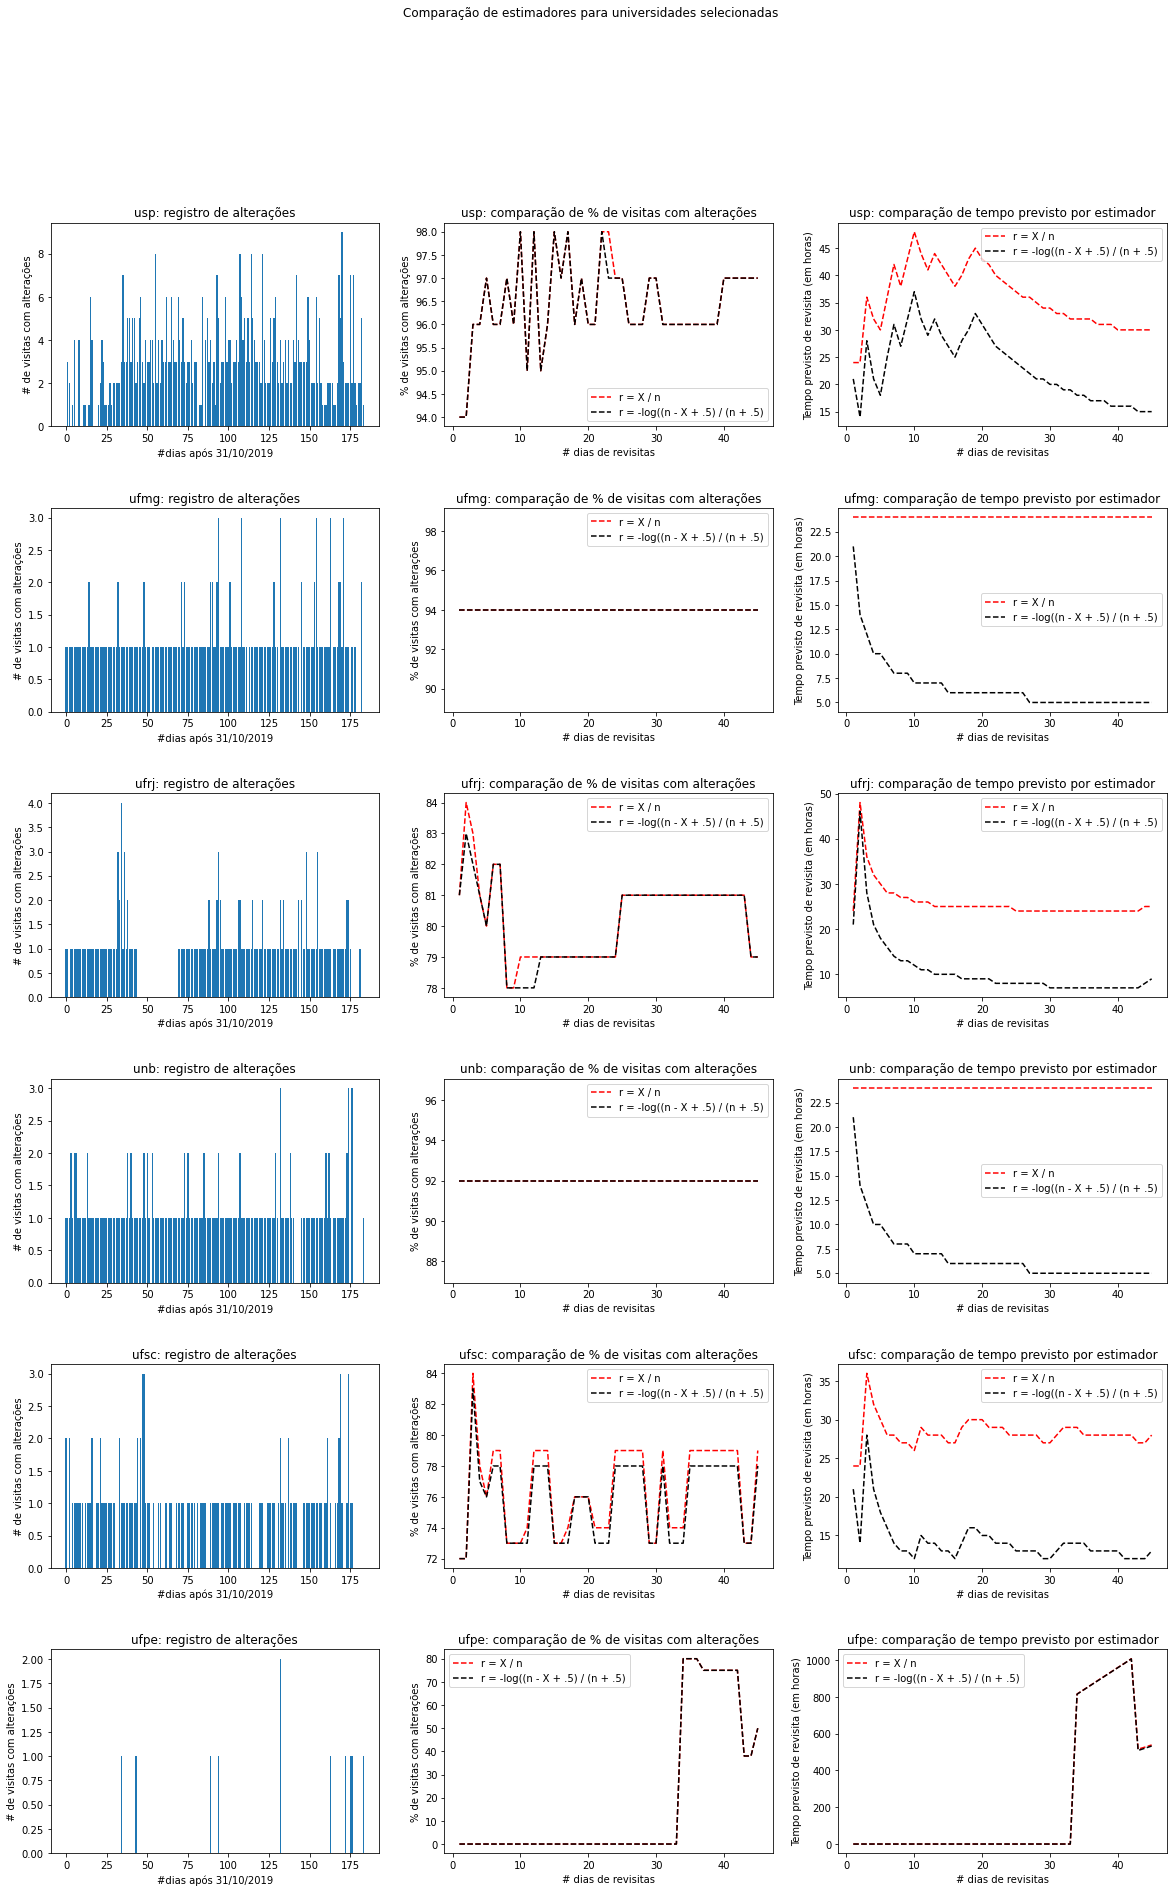

In [12]:
hists = [f_usp, f_ufmg, f_ufrj, f_unb, f_ufsc, f_ufpe]
data = [('usp',usp),('ufmg', ufmg), ('ufrj',ufrj),('unb',unb),('ufsc',ufsc),('ufpe', ufpe)]

plot_compare(hists, data, 'Comparação de estimadores para universidades selecionadas', 6, 3)

### Sites de notícis selecionados

In [7]:
f_g1 = calc_freq('g1')
f_elpais = calc_freq('elpais')
f_folha = calc_freq('folha')
f_metropoles = calc_freq('metropoles')
f_r7 = calc_freq('noticias_r7')
f_uol = calc_freq('noticias_uol')

g1  = run_experiment('g1', 45, 24)
elpais = run_experiment('elpais', 45, 24)
folha = run_experiment('folha', 45, 24)
metropoles  = run_experiment('metropoles', 45, 24)
r7 = run_experiment('noticias_r7', 45, 24)
uol = run_experiment('noticias_uol', 45, 24)

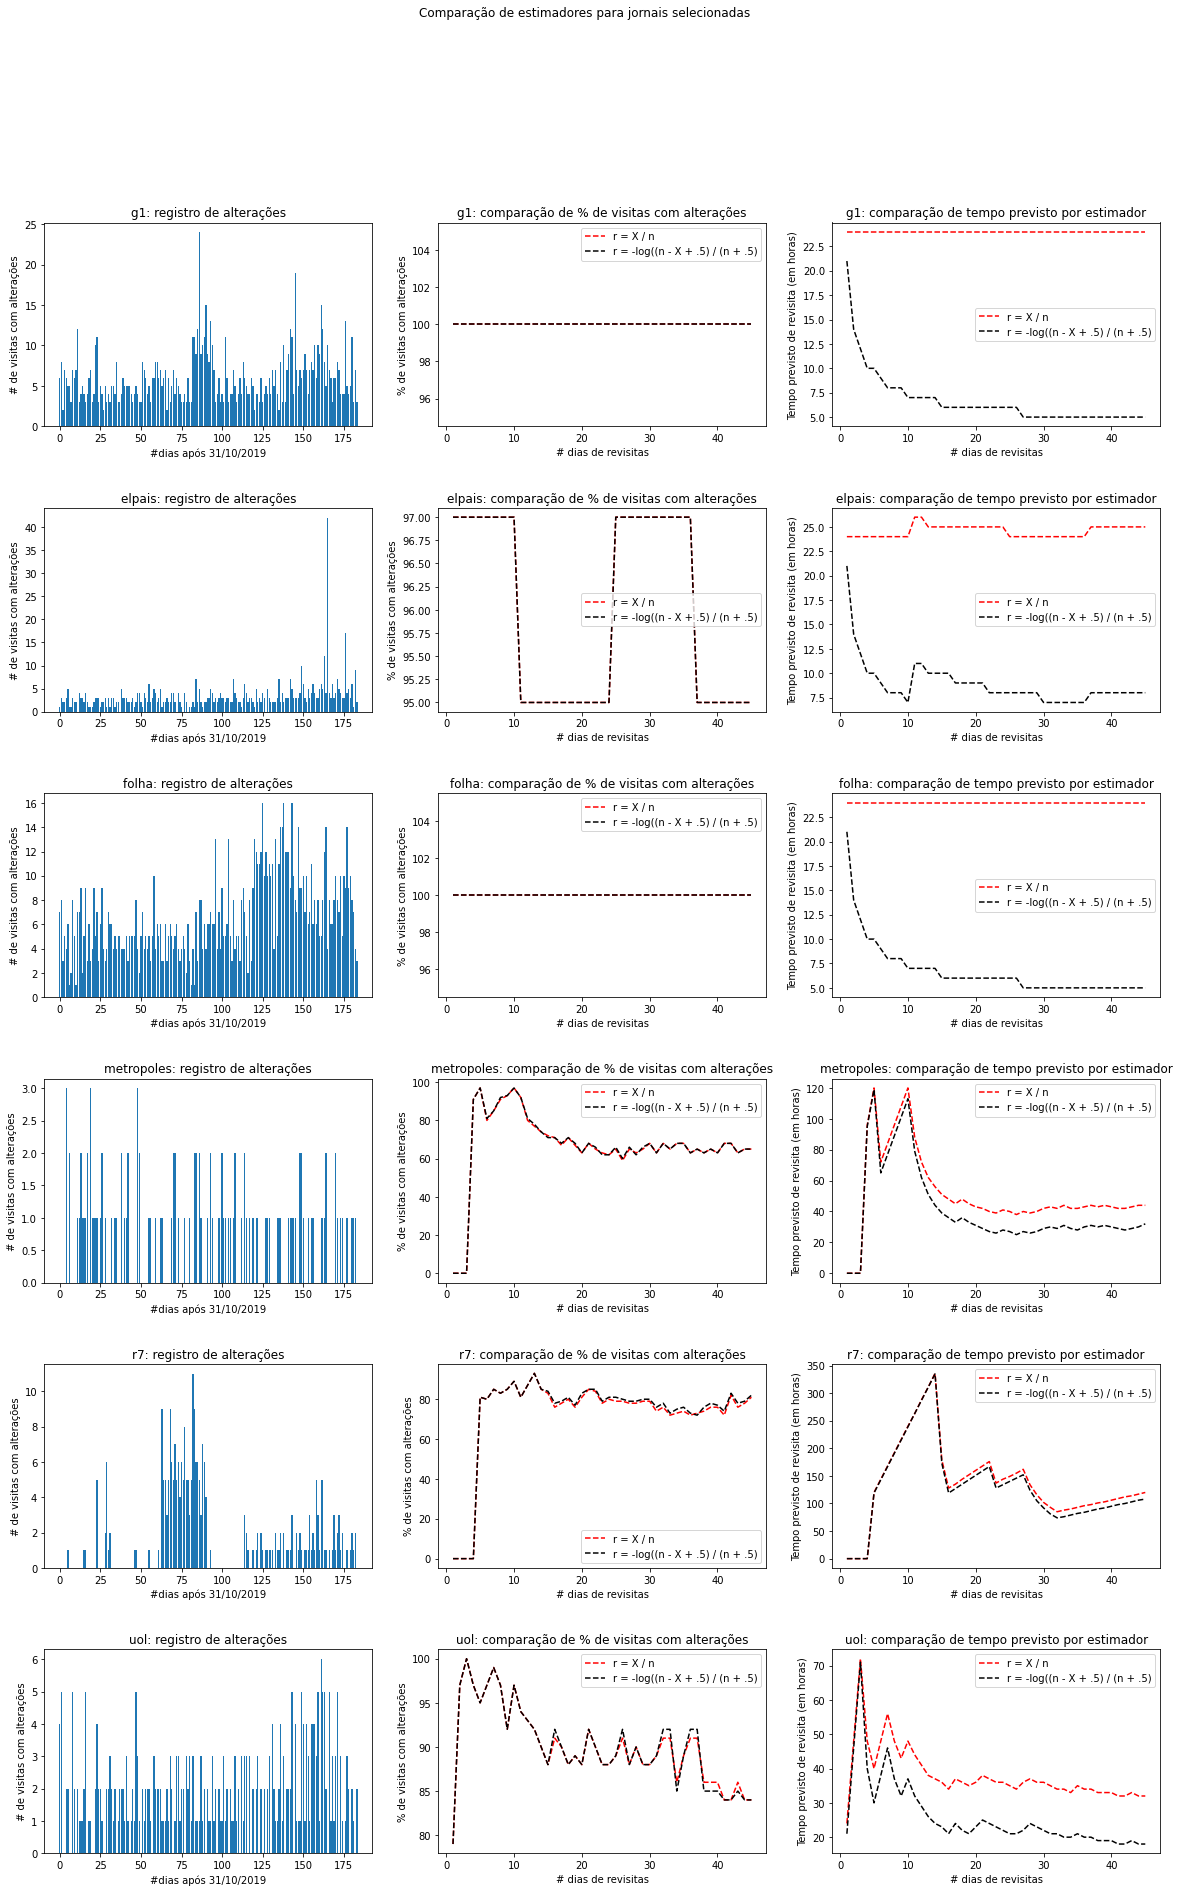

In [8]:
hists = [f_g1, f_elpais, f_folha, f_metropoles, f_r7, f_uol]
data = [('g1',g1),('elpais', elpais), ('folha',folha),('metropoles',metropoles),('r7',r7),('uol', uol)]

plot_compare(hists, data, 'Comparação de estimadores para jornais selecionadas', 6, 3)

### Sites governamentais selecionados

In [9]:
f_sp_state = calc_freq('saopaulo_estado')
f_rj_state = calc_freq('rj_estado')
f_mg       = calc_freq('mg')
f_es       = calc_freq('es')
f_sp_city  = calc_freq('sp_cidade')
f_rj_city  = calc_freq('rio_cidade')
f_pbh      = calc_freq('pbh')
f_vitoria  = calc_freq('vitoria')

sp_state = run_experiment('saopaulo_estado', 45, 24)
rj_state = run_experiment('rj_estado', 45, 24)
mg       = run_experiment('mg', 45, 24)
es       = run_experiment('es', 45, 24)
sp_city  = run_experiment('sp_cidade', 45, 24)
rj_city  = run_experiment('rio_cidade', 45, 24)
pbh      = run_experiment('pbh', 45, 24)
vitoria  = run_experiment('vitoria', 45, 24)

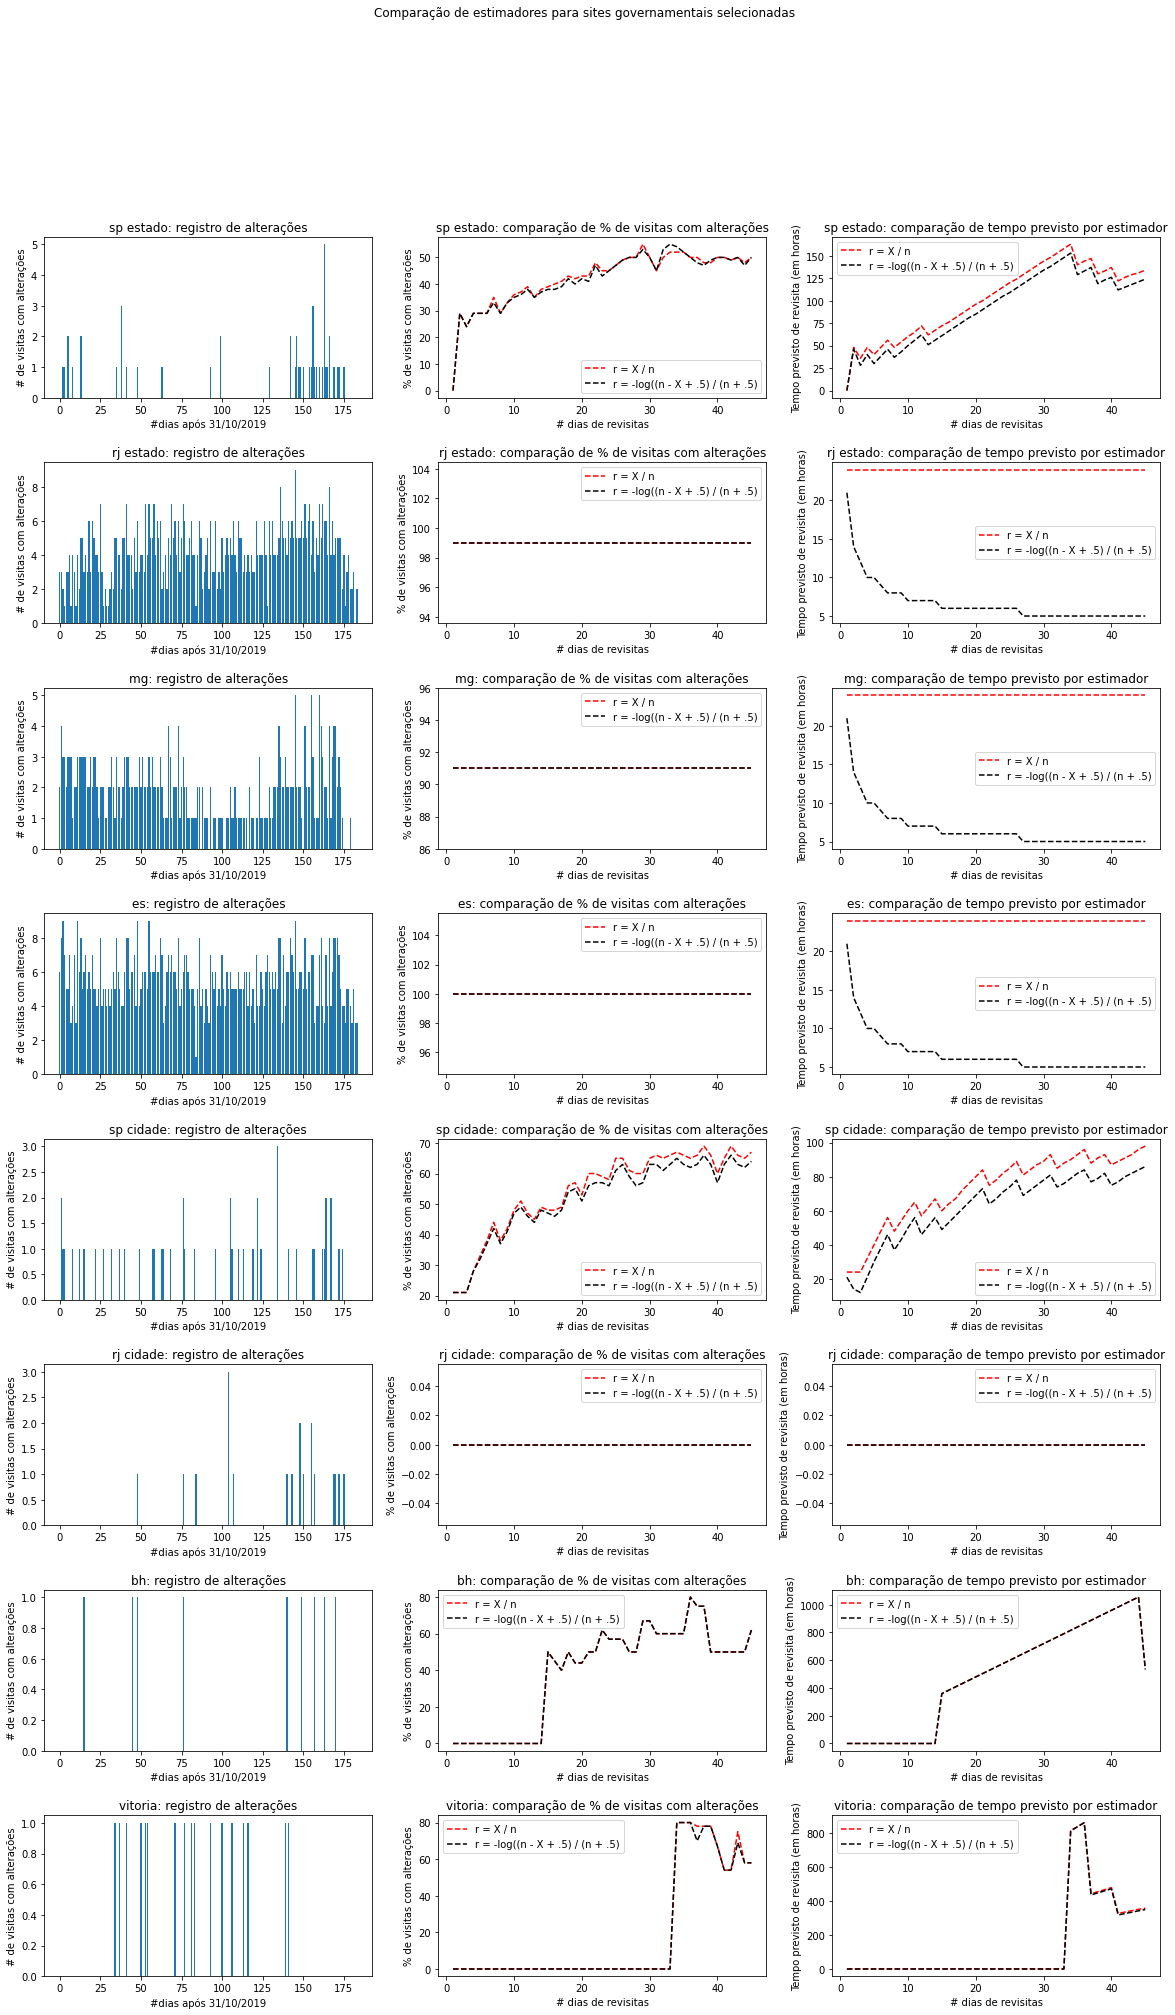

In [10]:
hists = [f_sp_state, f_rj_state, f_mg, f_es, f_sp_city, f_rj_city, f_pbh, f_vitoria]
data = [('sp estado',sp_state),('rj estado', rj_state), ('mg',mg),('es', es),('sp cidade',sp_city),('rj cidade', rj_city), ('bh', pbh), ('vitoria', vitoria)]

plot_compare(hists, data, 'Comparação de estimadores para sites governamentais selecionadas', 8, 3, figy=32)